In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem as ch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest
from sklearn.ensemble import RandomForestRegressor
import pickle as pkl
import seaborn as sns

RDKit WARNING: [08:44:31] Enabling RDKit 2019.09.3 jupyter extensions


<h3>SPLIT DATA FUNCTION</h3>

In [2]:
def split_data(X_new):
    X_final, validate = np.split(X_new.sample(frac=1), [int(.8*len(X_new))])
    X_train, X_test, y_train, y_test = train_test_split(X_final.drop(columns=['pChemBL'],inplace=False), X_final['pChemBL'], test_size=0.2, random_state=42)
    X_validate = validate.drop(columns='pChemBL',inplace=False).copy()
    y_validate = validate['pChemBL']
    return X_train, X_test, X_validate, y_train, y_test, y_validate

<h3>TRAIN RFR FUNCTION</h3>

In [3]:
def train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate):
    model2 = RandomForestRegressor(n_estimators= 150)
    model2.fit(X_train,y_train)
    r_square = model2.score(X_train,y_train)
    rmse = np.sqrt(mean_squared_error(model2.predict(X_train),y_train))
    print("Training set results:\nRMSE = {}\t R^2 = {}".format(rmse,r_square))
    q_square = model2.score(X_test,y_test)
    rmse = np.sqrt(mean_squared_error(model2.predict(X_test),y_test))
    print("Test set results\nRMSE = {}\t Q^2 = {}".format(rmse,q_square))
    q_square = model2.score(X_validate,y_validate)
    rmse = np.sqrt(mean_squared_error(y_validate,model2.predict(X_validate)))
    print("Validation set results\nRMSE = {}\t Q^2 = {}".format(rmse,q_square))    
    return model2

<h2>AKT MODEL-2</h2>

In [4]:
X= pd.read_csv('no_zeros_no_chembl.csv')
#X.drop(columns=['ChemBLID'],inplace=True)
X.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,pChemBL
0,0,-0.7109,0.505379,70.4932,73.378583,16,18,65,34,31,...,70.514766,2.073964,27.938805,11.267053,16.671753,3404,59,2.188,184,6.82
1,0,-1.4578,2.125181,44.0418,64.304653,18,20,52,31,21,...,65.167083,2.102164,17.955201,2.565237,15.389964,2593,55,6.575,180,7.64
2,0,0.0748,0.005595,27.2874,69.268860,27,29,57,37,20,...,76.232497,2.060338,31.795843,2.556014,22.098211,4979,56,5.589,198,4.30
3,0,-10.0458,100.918098,183.2952,142.418303,6,6,135,64,71,...,125.580825,1.962200,61.611922,20.276064,41.335857,21440,92,-0.194,302,6.03
4,0,-1.7897,3.203026,32.3564,58.685481,21,23,47,30,17,...,62.402934,2.080098,16.872064,13.655728,3.216336,2319,52,4.844,168,6.42


In [5]:
correlation_matrix = X.corr()
correlation_matrix.shape

(1209, 1209)

(array([345., 271., 217., 159., 114.,  69.,  19.,   7.,   5.,   2.]),
 array([6.86000008e-05, 3.71605334e-02, 7.42524668e-02, 1.11344400e-01,
        1.48436334e-01, 1.85528267e-01, 2.22620200e-01, 2.59712134e-01,
        2.96804067e-01, 3.33896001e-01, 3.70987934e-01]),
 <a list of 10 Patch objects>)

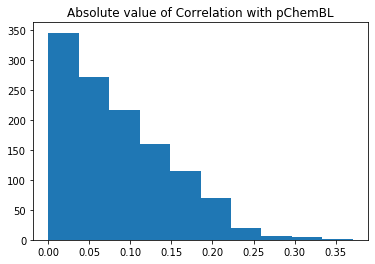

In [7]:
plt.title('Absolute value of Correlation with pChemBL')
plt.hist((correlation_matrix.iloc[:1208,1208]).abs())

In [8]:
bad_cols_index = []
for cols in range(1208):
    if correlation_matrix.abs().iloc[cols,1208] < 0.1:
        bad_cols_index.append(cols)
print(len(bad_cols_index))

bad_cols2 = []
cols = X.columns
for index in bad_cols_index:
    bad_cols2.append(cols[index])
len(bad_cols2)

757


757

In [9]:
X.drop(columns = bad_cols2, inplace = True)

In [10]:
X.shape

(2861, 452)

(array([345., 271., 217., 159., 114.,  69.,  19.,   7.,   5.,   2.]),
 array([6.86000008e-05, 3.71605334e-02, 7.42524668e-02, 1.11344400e-01,
        1.48436334e-01, 1.85528267e-01, 2.22620200e-01, 2.59712134e-01,
        2.96804067e-01, 3.33896001e-01, 3.70987934e-01]),
 <a list of 10 Patch objects>)

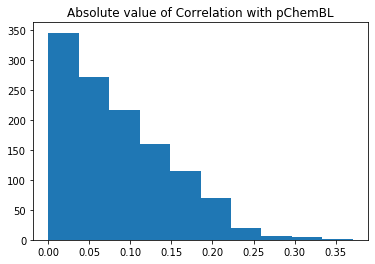

In [8]:
correlation_matrix = X.corr()
rows, cols = correlation_matrix.shape
plt.title('Absolute value of Correlation with pChemBL')
plt.hist((correlation_matrix.iloc[:(rows-1),rows-1]).abs())

In [9]:
bad_cols_index = []
for cols in range(rows-1):
    if correlation_matrix.abs().iloc[cols,rows-1] < 0.25:
        bad_cols_index.append(cols)
print(len(bad_cols_index))

bad_cols2 = []
cols = X.columns
for index in bad_cols_index:
    bad_cols2.append(cols[index])
len(bad_cols2)

1191


1191

In [10]:
X_try = X.drop(columns=bad_cols2,inplace=False).copy()
X_try.head()

,ATSC4c,ATSC2v,SCH-7,ASP-7,hmin,ETA_BetaP_s,IC1,IC2,SIC2,BIC2,ZMIC1,ZMIC2,MDEO-11,nHeteroRing,n6HeteroRing,nT6HeteroRing,LipinskiFailures,pChemBL
0,0.183691,808.584430,0.639198,0.027205,-0.189456,0.69853,3.498205,4.793532,0.795955,0.762645,51.535290,33.179219,0.000000,4,4,4,0,6.82
1,0.052198,-125.913748,1.013922,0.025619,-0.114131,0.65323,3.560855,4.402672,0.772339,0.718301,58.106835,36.787814,0.000000,3,2,2,1,7.64
2,-0.177672,-435.726504,0.622175,0.031451,-0.014566,0.68243,3.677764,4.767468,0.817342,0.761894,65.634530,39.004854,0.000000,3,2,2,1,4.30
3,-1.568588,-1158.676211,0.405022,0.033239,-0.177539,0.63281,3.492463,4.900736,0.692506,0.679765,108.296299,67.713621,2.886374,1,0,0,3,6.03
4,0.464528,150.179266,1.160056,0.025954,-0.117708,0.64167,3.468889,4.475247,0.805685,0.744481,61.609585,34.166117,0.655185,2,0,0,0,6.42


In [22]:
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_lol)

In [25]:
model1 = LinearRegression()
model1.fit(X_train,y_train)
r_square = model1.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(model1.predict(X_test),y_test))
print("Test set results\nRMSE = {}\t R^2 = {}".format(rmse,r_square))

Test set results
RMSE = 0.9657719395874582	 R^2 = 0.2707232396332827


In [26]:
rr = Ridge(alpha=0.001)
rr1 = Ridge(alpha=1)
rr2 = Ridge(alpha=1000)

In [27]:
rr.fit(X_train,y_train)
rr1.fit(X_train,y_train)
rr2.fit(X_train,y_train)

Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [28]:
r_square = rr.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(rr.predict(X_test),y_test))
print("Test set results\nRMSE = {}\t R^2 = {}".format(rmse,r_square))
r_square = rr1.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(rr1.predict(X_test),y_test))
print("Test set results\nRMSE = {}\t R^2 = {}".format(rmse,r_square))
r_square = rr2.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(rr2.predict(X_test),y_test))
print("Test set results\nRMSE = {}\t R^2 = {}".format(rmse,r_square))

Test set results
RMSE = 0.9655870349071923	 R^2 = 0.2710024645143161
Test set results
RMSE = 0.9669370921556286	 R^2 = 0.2689625107786966
Test set results
RMSE = 1.0286100605699529	 R^2 = 0.172734822006677


In [29]:
l = Lasso(alpha=0.001)
l1 = Lasso(alpha=0.1)
l2 = Lasso(alpha=0.01)

In [30]:
l.fit(X_train,y_train)
l1.fit(X_train,y_train)
l2.fit(X_train,y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
r_square = l.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(l.predict(X_test),y_test))
print("Test set results\nRMSE = {}\t R^2 = {}".format(rmse,r_square))
r_square = l1.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(l1.predict(X_test),y_test))
print("Test set results\nRMSE = {}\t R^2 = {}".format(rmse,r_square))
r_square = l2.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(l2.predict(X_test),y_test))
print("Test set results\nRMSE = {}\t R^2 = {}".format(rmse,r_square))

Test set results
RMSE = 0.9664722122175726	 R^2 = 0.2696652720460432
Test set results
RMSE = 1.0458835268612656	 R^2 = 0.1447169722531192
Test set results
RMSE = 0.9735882297659069	 R^2 = 0.25887094730607263


In [41]:
from sklearn.ensemble import RandomForestRegressor
model2 = RandomForestRegressor(n_estimators= 150)
model2.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [43]:
r_square = model2.score(X_train,y_train)
rmse = np.sqrt(mean_squared_error(model2.predict(X_train),y_train))
print("Training set results:\nRMSE = {}\t R^2 = {}".format(rmse,r_square))
q_square = model2.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(model2.predict(X_test),y_test))
print("Test set results\nRMSE = {}\t Q^2 = {}".format(rmse,q_square))
q_square = model2.score(X_validate,y_validate)
rmse = np.sqrt(mean_squared_error(y_validate,model2.predict(X_validate)))
print("Validation set results\nRMSE = {}\t Q^2 = {}".format(rmse,q_square))

Training set results:
RMSE = 0.3014686431847232	 R^2 = 0.9329120097126015
Test set results
RMSE = 0.7847904425853084	 Q^2 = 0.5184397631297106
Validation set results
RMSE = 0.7960686191878112	 Q^2 = 0.553739539653053


In [47]:
models = []
for i in range(5):
    print("\nDATASET {}".format(i+1))
    X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_try)
    models.append(train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate))
    train = X_train.copy()
    train['pChemBL'] = y_train
    train.to_csv('./data/train'+str(i)+'.csv')
    test = X_test.copy()
    test['pChemBL'] = y_test
    test.to_csv('./data/test'+str(i)+'.csv')
    validation = X_validate.copy()
    validation['pChemBL'] = y_validate
    validation.to_csv('./data/validation'+str(i)+'.csv')


DATASET 1
Training set results:
RMSE = 0.3013015244582267	 R^2 = 0.9338124991486569
Test set results
RMSE = 0.7924468215760563	 Q^2 = 0.5183661839782061
Validation set results
RMSE = 0.765770334115545	 Q^2 = 0.5680658032462265

DATASET 2
Training set results:
RMSE = 0.2983003916996915	 R^2 = 0.9354876941705035
Test set results
RMSE = 0.726900194299771	 Q^2 = 0.5712444020795474
Validation set results
RMSE = 0.7713985827138343	 Q^2 = 0.5712511138991998

DATASET 3
Training set results:
RMSE = 0.2947474000597755	 R^2 = 0.9339368298167487
Test set results
RMSE = 0.772550057200154	 Q^2 = 0.5801616987660878
Validation set results
RMSE = 0.7997484510858857	 Q^2 = 0.5489120351355846

DATASET 4
Training set results:
RMSE = 0.29567767099839787	 R^2 = 0.9358886810200453
Test set results
RMSE = 0.7590063817669721	 Q^2 = 0.5824451119464238
Validation set results
RMSE = 0.7752016861511418	 Q^2 = 0.5456693117870706

DATASET 5
Training set results:
RMSE = 0.3019129441159326	 R^2 = 0.9327152336201596
T

<h3>Summary</h3>
Best R^2 (train)      = DATASET 4(everything differs only in 10^-3)<br>
Best Q^2 (test)       = DATASET 5<br>
Best Q^2 (validation) = DATASET 2<br>
Overall Best Data split -> <b>DATASET 2</b>

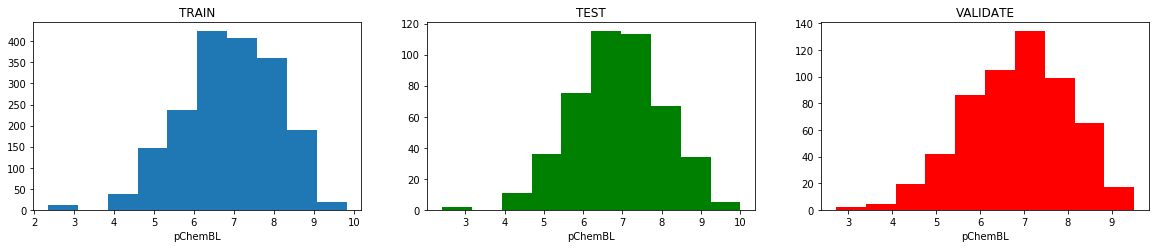

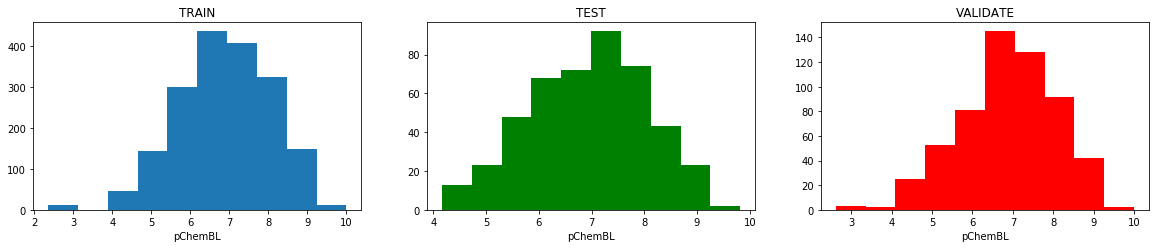

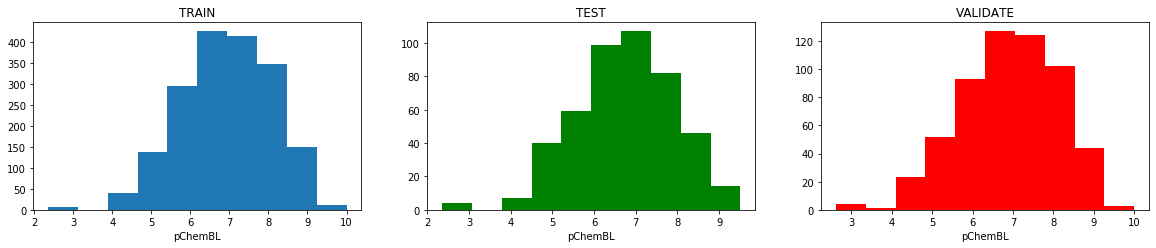

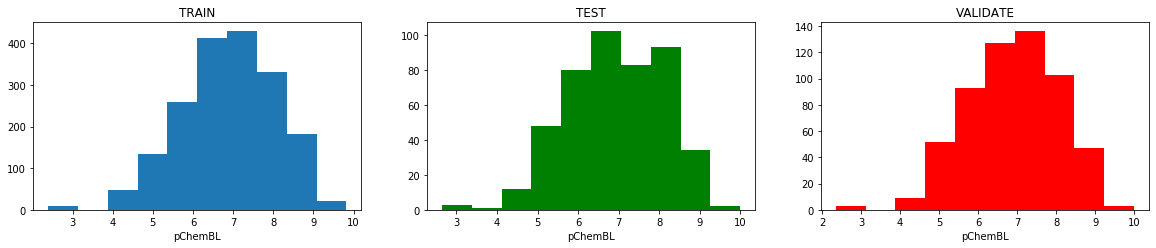

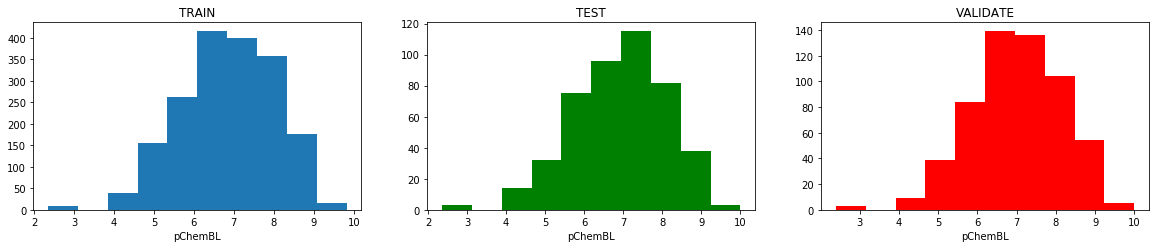

In [57]:
for i in range(5):
    plt.figure(figsize=(20,20))
    plt.subplot(5,3,3*i+1)
    train = pd.read_csv('./data/train'+str(i)+'.csv')
    
    test = pd.read_csv('./data/test'+str(i)+'.csv')
    validate = pd.read_csv('./data/validation'+str(i)+'.csv')
    plt.title('TRAIN')
    plt.xlabel('pChemBL')
    plt.hist(train['pChemBL'])
    plt.subplot(5,3,3*i+2)
    plt.xlabel('pChemBL')
    plt.title('TEST')
    plt.hist(test['pChemBL'],color='green')
    plt.subplot(5,3,3*i+3)
    plt.title('VALIDATE')
    plt.xlabel('pChemBL')
    plt.hist(validate['pChemBL'],color='red')

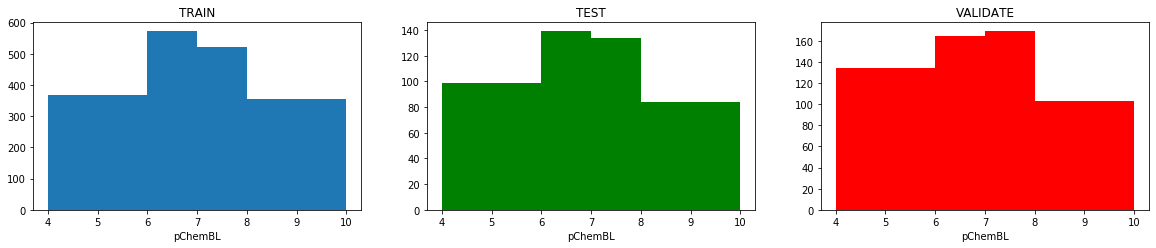

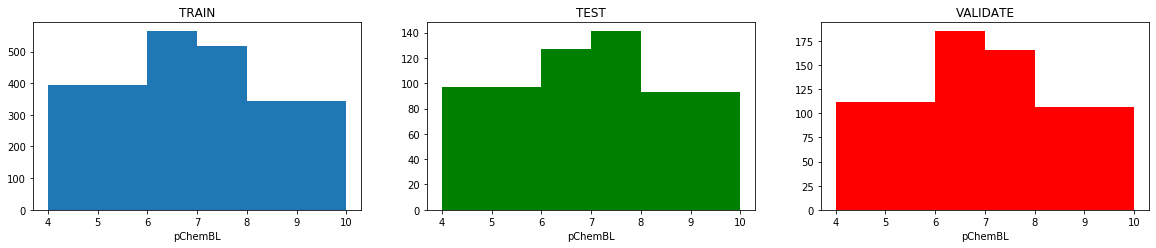

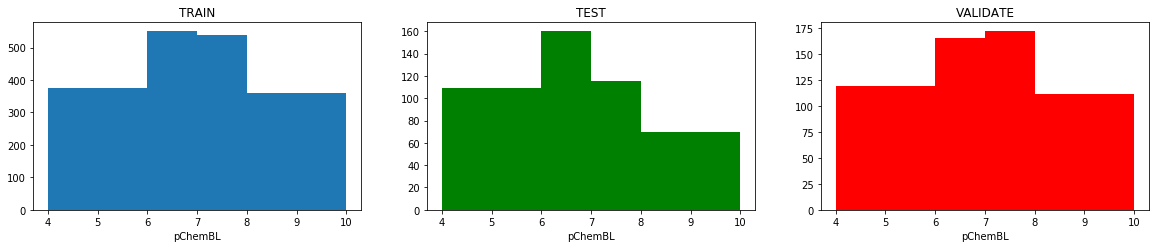

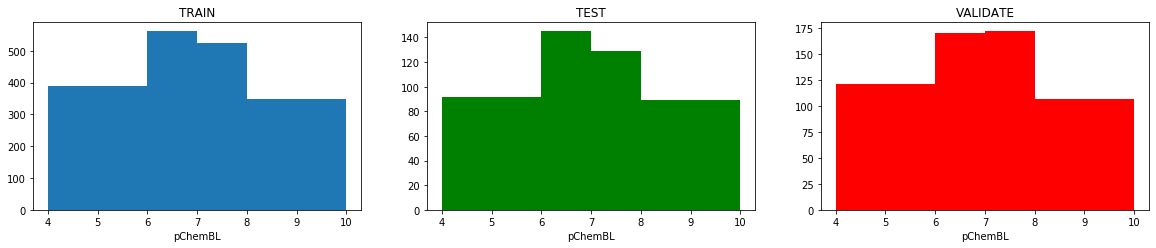

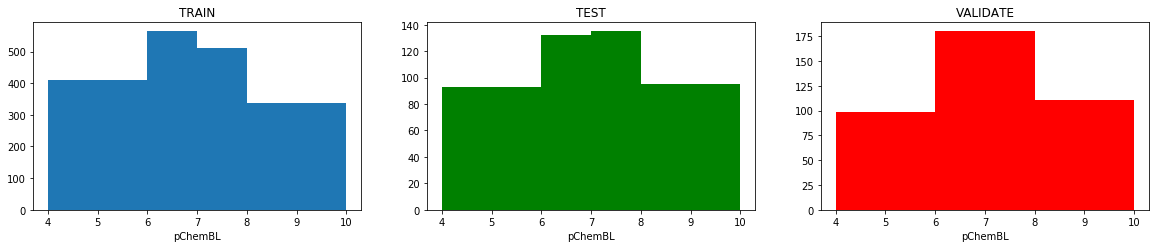

In [61]:
for i in range(5):
    bins = [4,6,7,8,10]
    plt.figure(figsize=(20,20))
    plt.subplot(5,3,3*i+1)
    train = pd.read_csv('./data/train'+str(i)+'.csv')
    test = pd.read_csv('./data/test'+str(i)+'.csv')
    validate = pd.read_csv('./data/validation'+str(i)+'.csv')
    plt.title('TRAIN')
    plt.xlabel('pChemBL')
    plt.hist(train['pChemBL'],bins=bins)
    plt.subplot(5,3,3*i+2)
    plt.xlabel('pChemBL')
    plt.title('TEST')
    plt.hist(test['pChemBL'],color='green',bins=bins)
    plt.subplot(5,3,3*i+3)
    plt.title('VALIDATE')
    plt.xlabel('pChemBL')
    plt.hist(validate['pChemBL'],color='red',bins=bins)

<h4>Random Forest Regressor with normalisation</h4>

In [68]:
models = []
from sklearn.preprocessing import StandardScaler
for i in range(5):
    print("\nDATASET {}".format(i+1))
    train = pd.read_csv('./data/train'+str(i)+'.csv')
    X_train = train.drop(columns='pChemBL',inplace=False)
    y_train = train['pChemBL']
    scaler = StandardScaler(copy=True)
    scaler.fit(X_train)
    X = scaler.transform(X_train)#.drop(columns=['ChemBLID'],inplace=False))
    X_train = pd.DataFrame(data=X,columns=X_train.columns)
    test = pd.read_csv('./data/test'+str(i)+'.csv')
    X_test = test.drop(columns='pChemBL',inplace=False)
    y_test = test['pChemBL']
    X = scaler.transform(X_test)
    X_test = pd.DataFrame(data=X,columns=X_test.columns)
    validate = pd.read_csv('./data/validation'+str(i)+'.csv')
    X_validate = validate.drop(columns='pChemBL',inplace=False)
    y_validate = validate['pChemBL']
    X = scaler.transform(X_validate)
    X_validate = pd.DataFrame(data=X,columns=X_test.columns)
    model = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)


DATASET 1


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Training set results:
RMSE = 0.281202157725047	 R^2 = 0.9423484985195044
Test set results
RMSE = 0.7417899402134879	 Q^2 = 0.5779745956797784
Validation set results
RMSE = 0.7258734029409973	 Q^2 = 0.6119012173867547

DATASET 2


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Training set results:
RMSE = 0.27763963301033506	 R^2 = 0.9441146672668734
Test set results
RMSE = 0.6932167244248182	 Q^2 = 0.6100595422223682
Validation set results
RMSE = 0.7335086064538805	 Q^2 = 0.6123357440351114

DATASET 3


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Training set results:
RMSE = 0.27820869723828534	 R^2 = 0.9411426303096134
Test set results
RMSE = 0.7350648110178425	 Q^2 = 0.6199155837891641
Validation set results
RMSE = 0.7660100304793359	 Q^2 = 0.5861686974907196

DATASET 4


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Training set results:
RMSE = 0.28027270673989113	 R^2 = 0.942395120835752
Test set results
RMSE = 0.732196507113153	 Q^2 = 0.6114221664031111
Validation set results
RMSE = 0.739923824095135	 Q^2 = 0.5860797466049559

DATASET 5


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Training set results:
RMSE = 0.27964618016626125	 R^2 = 0.9422740531337913
Test set results
RMSE = 0.7193416107386147	 Q^2 = 0.6395157818331578
Validation set results
RMSE = 0.7321152025772548	 Q^2 = 0.5852072151347352


<b>Summary:</b> Scaling reduces RMSE as well as increases Q^2

In [64]:
from sklearn.linear_model import ARDRegression
ARD = ARDRegression(normalize = True)
ARD.fit(X_train,y_train)
ARD.score(X_test,y_test)

0.29483860745933277

In [65]:
from sklearn.linear_model import ARDRegression
ARD = ARDRegression()
ARD.fit(X_train,y_train)
ARD.score(X_test,y_test)

0.29393488903750853

In [2]:
train = pd.read_csv('./data/train'+str(1)+'.csv')
test = pd.read_csv('./data/test'+str(1)+'.csv')
validate = pd.read_csv('./data/validation'+str(1)+'.csv')
frames = [train, test, validate]
result = pd.concat(frames)

In [24]:
linear_model = LinearRegression()
linear_model.fit(train.drop(columns='pChemBL',inplace=False),train['pChemBL'])
q_ = linear_model.score(test.drop(columns='pChemBL',inplace=False),test['pChemBL'])
rmse = np.sqrt(mean_squared_error(linear_model.predict(test.drop(columns='pChemBL',inplace=False)),test['pChemBL']))
print("RMSE ={}\nQ^2 = {}".format(rmse,q_))

RMSE =0.9178856979208991
Q^2 = 0.3163442996795902


(array([  3.,   2.,  25.,  53.,  81., 145., 128.,  92.,  42.,   2.]),
 array([ 2.61798296,  3.35618466,  4.09438637,  4.83258807,  5.57078977,
         6.30899148,  7.04719318,  7.78539489,  8.52359659,  9.2617983 ,
        10.        ]),
 <a list of 10 Patch objects>)

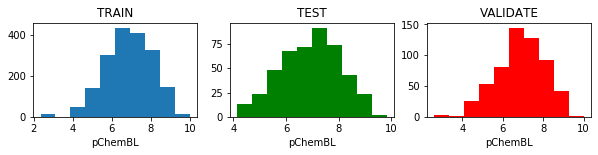

In [23]:
i = 0
plt.figure(figsize=(10,10))
plt.subplot(5,3,1)
plt.title('TRAIN')
plt.xlabel('pChemBL')
plt.hist(train['pChemBL'])
plt.subplot(5,3,3*i+2)
plt.xlabel('pChemBL')
plt.title('TEST')
plt.hist(test['pChemBL'],color='green')
plt.subplot(5,3,3*i+3)
plt.title('VALIDATE')
plt.xlabel('pChemBL')
plt.hist(validate['pChemBL'],color='red')

In [5]:
correlation_matrix = result.corr()

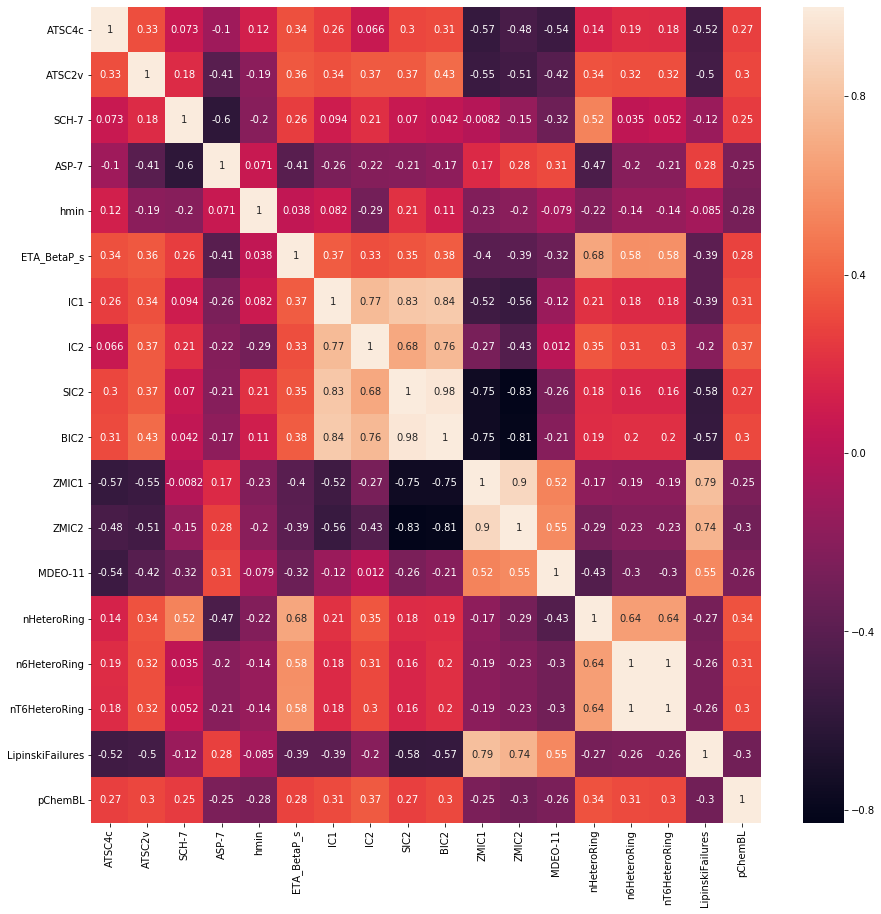

In [17]:
plt.figure(figsize=(15,15))
plot = sns.heatmap(correlation_matrix,annot=True)
plt.savefig('./heatmapwith annot.jpg')
plt.show()

In [43]:
models = []
i = 1
print("\nDATASET {}".format(i+1))
train = pd.read_csv('./data/train'+str(i)+'.csv')
X_train = train.drop(columns='pChemBL',inplace=False)
y_train = train['pChemBL']
scaler = StandardScaler(copy=True)
scaler.fit(X_train)
X = scaler.transform(X_train)#.drop(columns=['ChemBLID'],inplace=False))
X_train = pd.DataFrame(data=X,columns=X_train.columns)
test = pd.read_csv('./data/test'+str(i)+'.csv')
X_test = test.drop(columns='pChemBL',inplace=False)
y_test = test['pChemBL']
X = scaler.transform(X_test)
X_test = pd.DataFrame(data=X,columns=X_test.columns)
validate = pd.read_csv('./data/validation'+str(i)+'.csv')
X_validate = validate.drop(columns='pChemBL',inplace=False)
y_validate = validate['pChemBL']
X = scaler.transform(X_validate)
X_validate = pd.DataFrame(data=X,columns=X_test.columns)
model = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)


DATASET 2


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Training set results:
RMSE = 0.29713388849466377	 R^2 = 0.9359912581861661
Test set results
RMSE = 0.7283122594900334	 Q^2 = 0.5695769959897943
Validation set results
RMSE = 0.7653218253109645	 Q^2 = 0.5779795183451446


<h3>Confusion Matrix</h3>

In [15]:
y_pred = model.predict(X_test)
tp, tn, fp, fn = 0, 0, 0, 0
y = []
for val in y_test:
    if val<7:
        y.append(0)
    else:
        y.append(1)
yp = []
for val in y_pred:
    if val<7:
        yp.append(0)
    else:
        yp.append(1)

In [ ]:
for i in range(len(y)):
    v1,v2 = y[i],yp[i]
    if v1 and v2:
        tp += 1
    elif not(v1 or v2):
        tn += 1
    elif v1 == 1 and v2 ==0:
        fn +=1
    else:
        fp += 1

In [18]:
matrix = np.array([[tp,fp],[fn,tn]],dtype='float64')

In [19]:
print(matrix)

[[188.  38.]
 [ 46. 186.]]


In [21]:
p = (tp/(tp+fp))
print('Precision = ',p)
r = (tp/(tp+fn))
print('Recall = ',r)
print('F1 score = ',2*(p*r)/(p+r))

Precision =  0.831858407079646
Recall =  0.8034188034188035
F1 score =  0.817391304347826


<h2>Storing the required descriptors</h2>

In [26]:
df = pd.read_excel('Descriptors.xlsx',sheet_name='Detailed')
df.dropna(inplace=True)
df.head()

,Descriptor Java Class,Descriptor,Description,Class
0,AcidicGroupCountDescriptor,nAcid,Number of acidic groups. The list of acidic gr...,2D
1,ALOGPDescriptor,ALogP,Ghose-Crippen LogKow,2D
4,APolDescriptor,apol,Sum of the atomic polarizabilities (including ...,2D
5,AromaticAtomsCountDescriptor,naAromAtom,Number of aromatic atoms,2D
6,AromaticBondsCountDescriptor,nAromBond,Number of aromatic bonds,2D


In [28]:
all_types = np.asarray(df['Descriptor Java Class'])

In [60]:
required = ["RingCount","Autocorrelation","ChiChain","PaDELChiPath","ElectrotopologicalStateAtomType","ExtendedTopochemicalAtom","InformationContent","MDE","RuleOfFive"]

In [67]:
with open('./fd.xml','w') as f:
    f.write('<Root>\n    <Group name="2D">\n')
    for desc in new:
        if desc in required:
            f.write('        <Descriptor name="'+str(desc)+'" value="true"/>\n')
        else:
            f.write('        <Descriptor name="'+str(desc)+'" value="false"/>\n')
    f.write('    </Group>\n</Root>')

In [41]:
import re
new = []
for s in all_types:
    s = re.sub('Descriptor', '', s) 
    new.append(s)

In [42]:
new

['AcidicGroupCount',
 'ALOGP',
 'APol',
 'AromaticAtomsCount',
 'AromaticBondsCount',
 'AtomCount',
 'Autocorrelation',
 'BaryszMatrix',
 'BasicGroupCount',
 'BCUT',
 'PaDELBondCount',
 'BPol',
 'BurdenModifiedEigenvalues',
 'PaDELCarbonTypes',
 'ChiChain',
 'ChiCluster',
 'ChiPathCluster',
 'PaDELChiPath',
 'Constitutional',
 'Crippen',
 'DetourMatrix',
 'EccentricConnectivityIndex',
 'ElectrotopologicalStateAtomType',
 'ExtendedTopochemicalAtom',
 'FMF',
 'PaDELFragmentComplexity',
 'PaDELHBondAcceptorCount',
 'PaDELHBondDonorCount',
 'HybridizationRatio',
 'InformationContent',
 'KappaShapeIndices',
 'LargestChain',
 'LargestPiSystem',
 'LongestAliphaticChain',
 'MannholdLogP',
 'McGowanVolume',
 'MDE',
 'MLFER',
 'PathCount',
 'PetitjeanNumber',
 'RingCount',
 'PaDELRotatableBondsCount',
 'RuleOfFive',
 'Topological',
 'TopologicalCharge',
 'TopologicalDistanceMatrix',
 'TPSA',
 'VABC',
 'VAdjMa',
 'WalkCount',
 'PaDELWeight',
 'PaDELWeightedPath',
 'WienerNumbers',
 'XLogP',
 'Zag

In [11]:
df2 = pd.read_csv('./trial.csv')
bad = []
if "SP-7" in df2.columns:
    print(1)
else:
    print(0)

1


In [12]:
for col in df2.columns:
    if col not in X_train.columns:
        bad.append(col)
print(bad)
df2.drop(columns=bad,inplace=True)

['Name', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0e', 'ATS1e', 'ATS2e', 'ATS3e', 'ATS4e', 'ATS5e', 'ATS6e', 'ATS7e', 'ATS8e', 'ATS0p', 'ATS1p', 'ATS2p', 'ATS3p', 'ATS4p', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS8p', 'ATS0i', 'ATS1i', 'ATS2i', 'ATS3i', 'ATS4i', 'ATS5i', 'ATS6i', 'ATS7i', 'ATS8i', 'ATS0s', 'ATS1s', 'ATS2s', 'ATS3s', 'ATS4s', 'ATS5s', 'ATS6s', 'ATS7s', 'ATS8s', 'AATS0m', 'AATS1m', 'AATS2m', 'AATS3m', 'AATS4m', 'AATS5m', 'AATS6m', 'AATS7m', 'AATS8m', 'AATS0v', 'AATS1v', 'AATS2v', 'AATS3v', 'AATS4v', 'AATS5v', 'AATS6v', 'AATS7v', 'AATS8v', 'AATS0e', 'AATS1e', 'AATS2e', 'AATS3e', 'AATS4e', 'AATS5e', 'AATS6e', 'AATS7e', 'AATS8e', 'AATS0p', 'AATS1p', 'AATS2p', 'AATS3p', 'AATS4p', 'AATS5p', 'AATS6p', 'AATS7p', 'AATS8p', 'AATS0i', 'AATS1i', 'AATS2i', 'AATS3i', 'AATS4i', 'AATS5i', 'AATS6i', 'AATS7i', 'AATS8i', 'AATS0s', 'AATS1s', 'AATS2s', 'AATS3s', 'AATS4s', 'AATS

In [104]:
len(df2.columns)

17

In [103]:
len(X_try.columns)

18

In [110]:
cmd_list = ["java", "-jar", "C:\\Users\\HP\\PaDEL-Descriptor\\PaDEL-Descriptor.jar", "-dir","./mol", "-file","./trial.csv", "-2d", "-descriptortypes", 'fd.xml','-usefilenameasmolname']

<h3>Saving the model</h3>

In [5]:
i = 1
print("\nDATASET {}".format(i+1))
train = pd.read_csv('./data/train'+str(i)+'.csv')
X_train = train.drop(columns='pChemBL',inplace=False)
y_train = train['pChemBL']
scaler = StandardScaler(copy=True)
scaler.fit(X_train)
X = scaler.transform(X_train)#.drop(columns=['ChemBLID'],inplace=False))
X_train = pd.DataFrame(data=X,columns=X_train.columns)
test = pd.read_csv('./data/test'+str(i)+'.csv')
X_test = test.drop(columns='pChemBL',inplace=False)
y_test = test['pChemBL']
X = scaler.transform(X_test)
X_test = pd.DataFrame(data=X,columns=X_test.columns)
validate = pd.read_csv('./data/validation'+str(i)+'.csv')
X_validate = validate.drop(columns='pChemBL',inplace=False)
y_validate = validate['pChemBL']
X = scaler.transform(X_validate)
X_validate = pd.DataFrame(data=X,columns=X_test.columns)
model = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)


DATASET 2
Training set results:
RMSE = 0.29475911942030314	 R^2 = 0.9370103176157272
Test set results
RMSE = 0.7300750749763446	 Q^2 = 0.5674908726860093
Validation set results
RMSE = 0.7644826866055227	 Q^2 = 0.5789044614569528


In [6]:
with open('./saved_models/new_scaler.pkl','wb') as f:
    pkl.dump(scaler,f)
with open('./saved_models/new_RFR.pkl','wb') as f:
    pkl.dump(model,f)

In [24]:
print(len(bad))

1034


In [32]:
with open('./saved_models/drop.txt','wb') as f:
    pkl.dump(bad,f)

In [26]:
X_train.shape

(1830, 17)

In [8]:
import pickle
X = pd.read_csv('./descriptors.csv')
#y = X['pChemBL']
#X.drop(columns='pChemBL',inplace=True)
#Filling Null Values
X.fillna(value=0,inplace=True)
#Removing the columns with zero variance in original data
with open('./saved_models/drop.txt','rb') as fp:
    bad_cols = pickle.load(fp)
X_step1 = X.drop(columns=bad_cols,inplace=False)
X_step2 = X_step1



#Doing StandardScaler() as applied to original data
with open('./saved_models/new_scaler.pkl','rb') as fp:
    scaler = pickle.load(fp)
X2 = scaler.transform(X_step2.astype('float64'))
X_step3 = pd.DataFrame(data=X2,columns=X_step2.columns)

#X.head()
#Dropping columns with low correlation with pIC50

# =============================================================================
#     X.to_csv('./X.csv',index=False)
#     X_step1.to_csv('./X_step1.csv')
#     X_step2.to_csv('./X_step2.csv')
#     X_step3.to_csv('./X_step3.csv')
# =============================================================================



#Using the Random forest Predictor
with open('./saved_models/new_RFR.pkl','rb') as fp:
    pp = pickle.load(fp)
pp.predict(X_step3)

array([6.76038889, 6.83616833, 6.64931111, 6.72137717, 6.82115556,
       7.16074   , 7.39086667, 7.00673333, 7.48421984, 6.92455556,
       7.30871111, 7.23157778, 6.64908889, 6.67484444, 7.051     ,
       7.56206667, 6.92743333, 6.44477778, 7.11447111, 5.8927897 ,
       6.82100927, 6.36094444, 6.32282199, 7.1487    , 7.13258889,
       6.81987778, 7.5248    , 7.49273333, 7.2907    , 6.71488333,
       6.6837    , 7.06688889, 6.84569206, 7.51524444, 6.20306667,
       7.04193333, 6.76966667, 6.4916    , 6.21536667, 7.02874222,
       8.0026    , 7.0602    , 7.71516667, 6.64576667, 6.27248866,
       7.91226667, 6.82529556, 7.41936985, 7.18194444, 6.6545    ,
       7.31846667, 6.95378333, 7.24298262, 5.38987333, 6.64718889,
       7.42672222, 6.65246667, 6.96437   , 7.24205333, 7.13051429,
       6.1818    , 7.32953889, 6.82994667, 6.85104389, 7.24575556,
       6.974     , 6.97323333, 6.32305333, 7.15522222, 7.211     ,
       7.30778889, 7.03976667, 6.83856667, 6.92502778, 6.78050

In [7]:
X_train.head()

,ATSC4c,ATSC2v,SCH-7,ASP-7,hmin,ETA_BetaP_s,IC1,IC2,SIC2,BIC2,ZMIC1,ZMIC2,MDEO-11,nHeteroRing,n6HeteroRing,nT6HeteroRing,LipinskiFailures
0,0.578280,179.753983,0.369801,0.033885,0.072784,0.68750,3.988302,4.841615,0.871642,0.830054,38.680776,28.512776,0.388067,2,2,2,0
1,-0.115642,252.455141,0.621971,0.028386,0.072471,0.67188,4.396648,5.030633,0.916017,0.848231,42.295311,34.671329,0.512993,3,3,3,0
2,-0.097349,325.955735,0.578327,0.029740,-0.174475,0.65152,3.897113,4.760294,0.831068,0.772791,56.380963,38.830028,0.650698,2,0,0,0
3,0.464415,-30.113074,0.700831,0.026403,0.029772,0.68333,4.016156,4.604828,0.838483,0.771873,46.255943,34.935527,0.000000,3,2,2,0
4,-0.134785,349.032190,0.881447,0.028300,-0.053398,0.68519,3.757635,4.808388,0.856391,0.814030,39.266077,27.847084,0.200000,3,1,1,0


In [41]:
model.predict(X_step3)

array([7.76408889])

<h1>Explorations</h1>

In [9]:
import pickle
with open('./saved_models/new_RFR.pkl','rb') as fp:
    pp = pickle.load(fp)

In [7]:
X= pd.read_csv('no_zeros_no_chembl.csv')
#X.drop(columns=['ChemBLID'],inplace=True)
X.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,pChemBL
0,0,-0.7109,0.505379,70.4932,73.378583,16,18,65,34,31,...,70.514766,2.073964,27.938805,11.267053,16.671753,3404,59,2.188,184,6.82
1,0,-1.4578,2.125181,44.0418,64.304653,18,20,52,31,21,...,65.167083,2.102164,17.955201,2.565237,15.389964,2593,55,6.575,180,7.64
2,0,0.0748,0.005595,27.2874,69.268860,27,29,57,37,20,...,76.232497,2.060338,31.795843,2.556014,22.098211,4979,56,5.589,198,4.30
3,0,-10.0458,100.918098,183.2952,142.418303,6,6,135,64,71,...,125.580825,1.962200,61.611922,20.276064,41.335857,21440,92,-0.194,302,6.03
4,0,-1.7897,3.203026,32.3564,58.685481,21,23,47,30,17,...,62.402934,2.080098,16.872064,13.655728,3.216336,2319,52,4.844,168,6.42


In [8]:
correlation_matrix = X.corr()
correlation_matrix.shape

(1209, 1209)

In [9]:
rows, cols = correlation_matrix.shape
bad_cols_index = []
for cols in range(rows-1):
    if correlation_matrix.abs().iloc[cols,rows-1] < 0.25:
        bad_cols_index.append(cols)
print(len(bad_cols_index))

bad_cols2 = []
cols = X.columns
for index in bad_cols_index:
    bad_cols2.append(cols[index])
len(bad_cols2)

1191


1191

In [10]:
X.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,pChemBL
0,0,-0.7109,0.505379,70.4932,73.378583,16,18,65,34,31,...,70.514766,2.073964,27.938805,11.267053,16.671753,3404,59,2.188,184,6.82
1,0,-1.4578,2.125181,44.0418,64.304653,18,20,52,31,21,...,65.167083,2.102164,17.955201,2.565237,15.389964,2593,55,6.575,180,7.64
2,0,0.0748,0.005595,27.2874,69.268860,27,29,57,37,20,...,76.232497,2.060338,31.795843,2.556014,22.098211,4979,56,5.589,198,4.30
3,0,-10.0458,100.918098,183.2952,142.418303,6,6,135,64,71,...,125.580825,1.962200,61.611922,20.276064,41.335857,21440,92,-0.194,302,6.03
4,0,-1.7897,3.203026,32.3564,58.685481,21,23,47,30,17,...,62.402934,2.080098,16.872064,13.655728,3.216336,2319,52,4.844,168,6.42


In [11]:
X_try = X.drop(columns=bad_cols2,inplace=False).copy()
X_try.head()

,ATSC4c,ATSC2v,SCH-7,ASP-7,hmin,ETA_BetaP_s,IC1,IC2,SIC2,BIC2,ZMIC1,ZMIC2,MDEO-11,nHeteroRing,n6HeteroRing,nT6HeteroRing,LipinskiFailures,pChemBL
0,0.183691,808.584430,0.639198,0.027205,-0.189456,0.69853,3.498205,4.793532,0.795955,0.762645,51.535290,33.179219,0.000000,4,4,4,0,6.82
1,0.052198,-125.913748,1.013922,0.025619,-0.114131,0.65323,3.560855,4.402672,0.772339,0.718301,58.106835,36.787814,0.000000,3,2,2,1,7.64
2,-0.177672,-435.726504,0.622175,0.031451,-0.014566,0.68243,3.677764,4.767468,0.817342,0.761894,65.634530,39.004854,0.000000,3,2,2,1,4.30
3,-1.568588,-1158.676211,0.405022,0.033239,-0.177539,0.63281,3.492463,4.900736,0.692506,0.679765,108.296299,67.713621,2.886374,1,0,0,3,6.03
4,0.464528,150.179266,1.160056,0.025954,-0.117708,0.64167,3.468889,4.475247,0.805685,0.744481,61.609585,34.166117,0.655185,2,0,0,0,6.42


In [26]:
X_try.to_csv('./X17.csv')

In [63]:
X_try = pd.read_csv('./X17.csv')
X_try.head()

,ATSC4c,ATSC2v,SCH-7,ASP-7,hmin,ETA_BetaP_s,IC1,IC2,SIC2,BIC2,ZMIC1,ZMIC2,MDEO-11,nHeteroRing,n6HeteroRing,nT6HeteroRing,LipinskiFailures,pChemBL
0,0.183691,808.584430,0.639198,0.027205,-0.189456,0.69853,3.498205,4.793532,0.795955,0.762645,51.535290,33.179219,0.000000,4,4,4,0,6.82
1,0.052198,-125.913748,1.013922,0.025619,-0.114131,0.65323,3.560855,4.402672,0.772339,0.718301,58.106835,36.787814,0.000000,3,2,2,1,7.64
2,-0.177672,-435.726504,0.622175,0.031451,-0.014566,0.68243,3.677764,4.767468,0.817342,0.761894,65.634530,39.004854,0.000000,3,2,2,1,4.30
3,-1.568588,-1158.676211,0.405022,0.033239,-0.177539,0.63281,3.492463,4.900736,0.692506,0.679765,108.296299,67.713621,2.886374,1,0,0,3,6.03
4,0.464528,150.179266,1.160056,0.025954,-0.117708,0.64167,3.468889,4.475247,0.805685,0.744481,61.609585,34.166117,0.655185,2,0,0,0,6.42


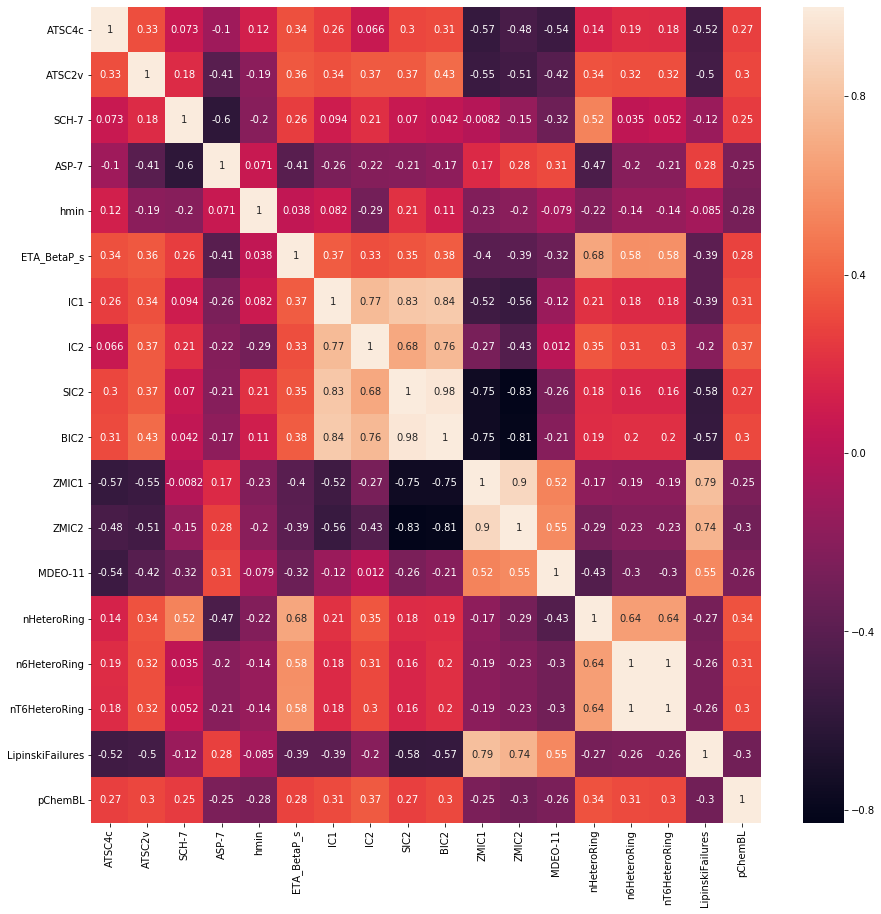

In [13]:
mat = X_try.corr()
plt.figure(figsize=(15,15))
sns.heatmap(mat,annot=True)
plt.show()

In [10]:
mat.shape

(18, 18)

In [24]:
X_try2 = X_try.drop(columns=['ZMIC1','SIC2','IC1','nT6HeteroRing','LipinskiFailures'],inplace=False)

In [25]:
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_try2)
model=train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.29163578305840543	 R^2 = 0.9381236824086415
Test set results
RMSE = 0.7734585110204392	 Q^2 = 0.5242157674858365
Validation set results
RMSE = 0.826755742497236	 Q^2 = 0.5060865146067871


In [ ]:
print(clusters[20])
(553, 297, 547)

#now display structures from one of the clusters
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

m1 = ms[553]
m2 = ms[297]
m3 = ms[547]
mols=(m1,m2,m3)
Draw.MolsToGridImage(mols)

In [52]:
from chemfp.bitops import byte_tanimoto
cluster_generator = JarvisPatrick(fps, byte_tanimoto)
cluster = cluster_generator(9, 8)

ModuleNotFoundError: No module named 'chemfp'

<h3>K-Means trials</h3>

In [62]:
from numpy import unique
from numpy import where
from sklearn.cluster import KMeans
# define dataset
nc = 5
# define the model
model = KMeans(n_clusters=nc)
# fit the model
model.fit(X_try)

NameError: name 'X_try' is not defined

In [93]:
# assign a cluster to each example
yhat = model.predict(X_try)
# retrieve unique clusters
ylol = pd.Series(data=yhat)
print(len(ylol))

2861


In [94]:
ylol

0       1
1       4
2       4
3       2
4       0
       ..
2856    3
2857    1
2858    4
2859    4
2860    0
Length: 2861, dtype: int32

<BarContainer object of 5 artists>

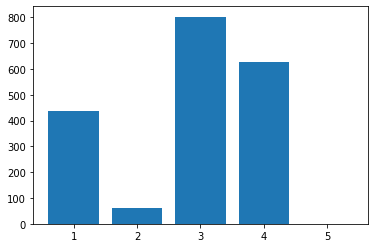

In [95]:
countc = []
for i in range(1,(nc)+1):
    countc.append(ylol.loc[ylol==i].count())
plt.bar(range(1,(nc+1)),countc)

<h2>Linear on RFR model</h2>

In [7]:
with open('./saved_models/new_scaler.pkl','rb') as fp:
    scaler = pkl.load(fp)
X2 = scaler.transform(X_try.drop(columns='pChemBL',inplace=False).astype('float64'))
X_step3 = pd.DataFrame(data=X2,columns=X_try.drop(columns='pChemBL',inplace=False).columns)
#pp.score(X_step3,X_try['pChemBL'])

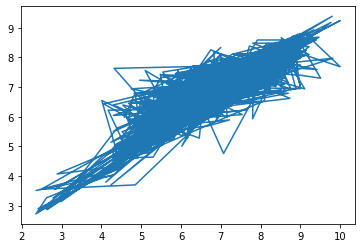

In [10]:
plt.plot(X_try['pChemBL'],pp.predict(X_step3))

In [ ]:
s = StandardScaler()
s.fit(X_try.drop(columns='pChemBL',inplace=False).astype('float64'))
X2 = scaler.transform(X_try.drop(columns='pChemBL',inplace=False).astype('float64'))
X_step3 = pd.DataFrame(data=X2,columns=X_try.drop(columns='pChemBL',inplace=False).columns)
X_step3['pChemBL'] = X_try['pChemBL']
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_step3)
model=train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

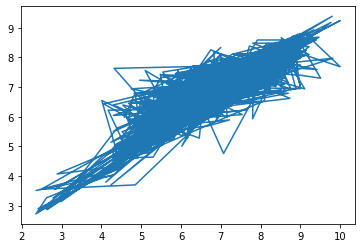

In [14]:
plt.plot(X_try['pChemBL'],pp.predict(X_step3.drop(columns='pChemBL',inplace=False)))

In [17]:
model.score(X_try.drop(columns='pChemBL',inplace=False),X_try['pChemBL'])

0.8023075986740092

In [17]:
model1 = LinearRegression()
pred = pp.predict(X_step3)
X_train, X_test, y_train, y_test = train_test_split(pred,X_try['pChemBL'],test_size=0.25)
model1.fit(X_train.reshape(-1,1),y_train)
r_square = model1.score(X_test.reshape(-1,1),y_test)
rmse = np.sqrt(mean_squared_error(model1.predict(X_test.reshape(-1, 1)),y_test))
print("Test set results\nRMSE = {}\t R^2 = {}".format(rmse,r_square))

Test set results
RMSE = 0.47899595634554365	 R^2 = 0.8298877522272652


In [18]:
final_pred = model1.predict(pred.reshape(-1,1))

In [23]:
pred = model.predict(X_validate)
final_pred = model1.predict(pred.reshape(-1,1))
mean = np.full(X_validate.shape[0],y_validate.mean())
mse_ = mean_squared_error(y_validate,mean)
mse = (mean_squared_error(y_validate,final_pred))
r2 =  1 - mse/mse_
print("RMSE = {}\nQ^2 = {}".format(np.sqrt(mse),r2))

RMSE = 0.7465435519535069
Q^2 = 0.5806446748804595


A slight improvement

<h2>Implementing t-SNE</h2>

<h3>17 features+pChemBL

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,init='pca',verbose=1)
tsne_exact = TSNE(n_components=2,init='pca',method='exact',verbose=1)

x_t = tsne.fit_transform(X_try)
x_t2 = tsne_exact.fit_transform(X_try)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2861 samples in 0.003s...
[t-SNE] Computed neighbors for 2861 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2861
[t-SNE] Computed conditional probabilities for sample 2000 / 2861
[t-SNE] Computed conditional probabilities for sample 2861 / 2861
[t-SNE] Mean sigma: 8.767688
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.824619
[t-SNE] KL divergence after 1000 iterations: 0.397429
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2861
[t-SNE] Computed conditional probabilities for sample 2000 / 2861
[t-SNE] Computed conditional probabilities for sample 2861 / 2861
[t-SNE] Mean sigma: 8.763419
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.882889
[t-SNE] KL divergence after 1000 iterations: 0.396825


In [29]:
x_t.shape

(2861, 2)

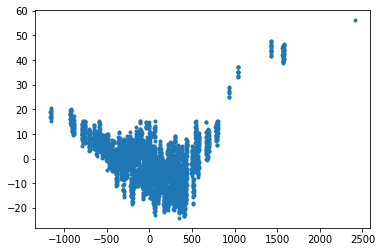

In [40]:
plt.plot(x_t[:,0],x_t[:,1],'.')

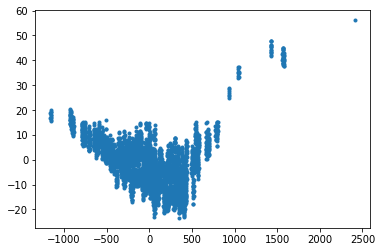

In [45]:
plt.plot(x_t2[:,0],x_t2[:,1],'.')

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2861 samples in 0.002s...
[t-SNE] Computed neighbors for 2861 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2861
[t-SNE] Computed conditional probabilities for sample 2000 / 2861
[t-SNE] Computed conditional probabilities for sample 2861 / 2861
[t-SNE] Mean sigma: 4.905116
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.470039
[t-SNE] KL divergence after 1000 iterations: 0.386734


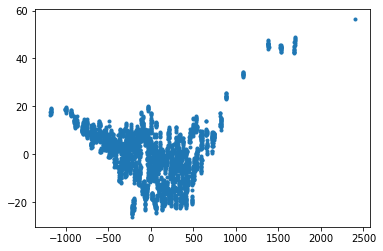

In [46]:
tsne = TSNE(n_components=2,init='pca',verbose=1,perplexity=10)
x_t = tsne.fit_transform(X_try)
plt.plot(x_t[:,0],x_t[:,1],'.')

In [ ]:
tsne = TSNE(n_components=3,init='pca',verbose=1)
x_t = tsne.fit_transform(X_try)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

In [73]:
df = pd.DataFrame(data=x_t,columns=['1','2','3'])
df.to_csv('tSNE_3D.csv',index=False)

<h4>17 features without pChemBL

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2861 samples in 0.009s...
[t-SNE] Computed neighbors for 2861 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2861
[t-SNE] Computed conditional probabilities for sample 2000 / 2861
[t-SNE] Computed conditional probabilities for sample 2861 / 2861
[t-SNE] Mean sigma: 8.755023
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.927467
[t-SNE] KL divergence after 1000 iterations: 0.381227
Shape of x_t (2861, 2)


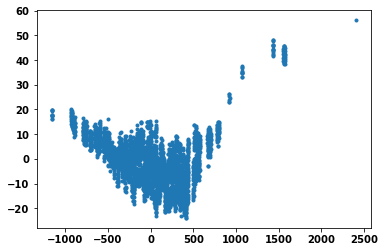

In [65]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,init='pca',verbose=1)
x_t = tsne.fit_transform(X_try.drop(columns='pChemBL',inplace=False))
print('Shape of x_t',x_t.shape)
plt.plot(x_t[:,0],x_t[:,1],'.')

<h3>With some more features

In [4]:
X = pd.read_csv('no_zeros_no_chembl.csv')
correlation_matrix = X.corr()
bad_cols_index = []
for cols in range(1208):
    if correlation_matrix.abs().iloc[cols,1208] < 0.1:
        bad_cols_index.append(cols)
print(len(bad_cols_index))

bad_cols2 = []
cols = X.columns
for index in bad_cols_index:
    bad_cols2.append(cols[index])
len(bad_cols2)

757


757

In [5]:
X.drop(columns=bad_cols2,inplace=True)

In [6]:
y = X['pChemBL']
X.drop(columns='pChemBL',inplace=True)

<h3>Mutual Info Regression performed on 452 features</h3>(for feature selection)

In [77]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
X_new = SelectKBest(mutual_info_regression, k=50).fit_transform(X, y)

cols = []
for i in range(50):
    cols.append('comp'+str(i+1))
X_red = pd.DataFrame(data=X_new, columns=cols)

(array([17., 11.,  8.,  5.,  2.,  1.,  2.,  3.,  0.,  1.]),
 array([0.10101353, 0.12449249, 0.14797145, 0.17145042, 0.19492938,
        0.21840835, 0.24188731, 0.26536627, 0.28884524, 0.3123242 ,
        0.33580316]),
 <a list of 10 Patch objects>)

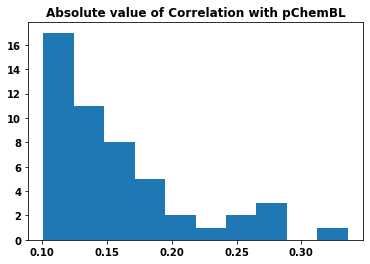

In [80]:
X_red['pChemBL'] = y
corr_matrix = X_red.corr()
plt.title('Absolute value of Correlation with pChemBL')
plt.hist((corr_matrix.iloc[:len(cols),len(cols)]).abs())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2861 samples in 0.039s...
[t-SNE] Computed neighbors for 2861 samples in 0.346s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2861
[t-SNE] Computed conditional probabilities for sample 2000 / 2861
[t-SNE] Computed conditional probabilities for sample 2861 / 2861
[t-SNE] Mean sigma: 6.107326
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.743423
[t-SNE] KL divergence after 1000 iterations: 0.541202
Shape of x_t (2861, 2)


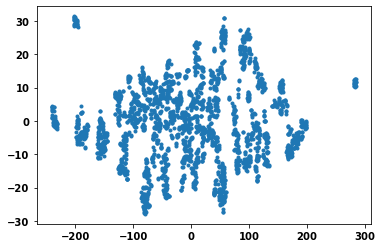

In [81]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,init='pca',verbose=1)
x_t = tsne.fit_transform(X_red)
print('Shape of x_t',x_t.shape)
plt.plot(x_t[:,0],x_t[:,1],'.')

In [92]:
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_red)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.2640578932983205	 R^2 = 0.9509766910448381
Test set results
RMSE = 0.6594638081557663	 Q^2 = 0.6714872397300438
Validation set results
RMSE = 0.6725619696869898	 Q^2 = 0.6157031300553855


In [89]:
scale = StandardScaler()
anon = X_red.drop(columns='pChemBL',inplace=False)
scale.fit(anon)
a = scale.transform(anon)
anon = pd.DataFrame(data=a,columns = anon.columns)
anon['pChemBL'] = X_red['pChemBL']
anon.head()

,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,comp9,comp10,...,comp42,comp43,comp44,comp45,comp46,comp47,comp48,comp49,comp50,pChemBL
0,-0.351928,0.225817,-1.302195,0.570100,0.382146,0.326812,0.656777,0.522070,0.447225,0.726585,...,-0.378044,1.085501,0.233193,0.653632,0.732004,0.834264,0.824194,1.173686,-0.209875,6.82
1,-0.351928,-0.138740,1.765971,0.807637,-0.350463,-1.058278,-1.000160,0.548928,-0.212760,-0.579420,...,-0.378044,-0.014287,-0.727830,0.980360,1.031408,1.067285,-0.088705,-0.719429,-0.398305,7.64
2,0.523607,-0.776044,0.199628,0.703677,-0.238897,-0.210956,0.148180,1.007079,0.585002,0.549196,...,-0.378044,0.203337,-0.727830,0.489264,0.483153,0.507164,-0.088705,-0.721436,0.587844,4.30
3,4.025748,-4.632288,2.721977,1.278363,1.865578,2.334750,2.646201,1.211694,2.389423,2.791551,...,4.759578,-0.325660,-0.727830,-1.935419,-1.865746,-1.971017,-1.914504,3.133633,3.415884,6.03
4,-2.102998,1.004422,1.686057,-0.259085,-0.568936,-0.417660,-1.195183,-0.385867,-0.399293,-1.012185,...,0.788157,-1.421030,-0.727830,0.948702,0.917908,0.884662,-1.001605,1.693352,-2.187896,6.42


In [105]:
scale = StandardScaler()
anon = X_red.drop(columns='pChemBL',inplace=False)
scale.fit(anon)
a = scale.transform(anon)
anon = pd.DataFrame(data=a,columns = anon.columns)
anon['pChemBL'] = X_try['pChemBL']
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(anon)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.27289866209770247	 R^2 = 0.9441413471318102
Test set results
RMSE = 0.6698488549617897	 Q^2 = 0.6634389367667869
Validation set results
RMSE = 0.6735866354140885	 Q^2 = 0.6876581119589311


<h3>Butina Clustering

In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

#Define clustering setup
def ClusterFps(fps,cutoff=0.2):
    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs

In [7]:
df = pd.read_excel('C:\\Users\\HP\\AZC_Internship\\Data\\ChemBL\\AKT-binding_simplified.xlsx',sheet_name='Step3')
df.head()

,Sno,ChEMBL_ID,Smiles,Standard_Value,Standard_Units,pChEMBL_Value,Class
0,1,CHEMBL3403664,C[C@H](Nc1ncnc(N)c1C#N)c1nc2ccc(F)cc2c(S(C)(=O...,0.10,nM,10.00,1
1,2,CHEMBL3899716,Cc1cc(-c2cn(CCN3CCC3)c(C3CCN(c4ncnc(N)c4Br)CC3...,0.10,nM,10.00,1
2,3,CHEMBL3966806,CC(C)c1cc(-c2cn(CCN3CCC3)c(C3CCN(c4ncnc(N)c4Br...,0.15,nM,9.82,1
3,4,CHEMBL379300,Cc1n[nH]c2ccc(-c3cncc(OC[C@@H](N)Cc4c[nH]c5ccc...,0.16,nM,9.80,1
4,5,CHEMBL573326,N[C@H](COc1cncc(-c2ccc3c(c2)C(c2ccco2)C(=O)N3)...,0.17,nM,9.77,1


In [9]:
mol = []
for row in df.iterrows():
    mol.append(Chem.MolFromSmiles(row[1]['Smiles']))
len(mol)

2861

In [ ]:
fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in mol]

In [ ]:
nc = []
for i in range(20):
    clusters=ClusterFps(fps,cutoff=i/20)
    nc.append(len(clusters))

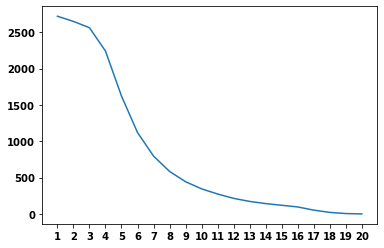

In [22]:
plt.xticks(range(1,21))
plt.plot(range(1,21),nc)

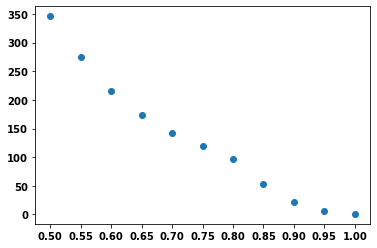

In [28]:
plt.xticks(np.asarray(range(10,21))/20)
plt.scatter(np.asarray(range(10,21))/20,nc[9:])

In [59]:
clusters=ClusterFps(fps,cutoff=0.7)

c = np.asarray(clusters)
l = []
for arr in c:
    l.append(len(arr))

<BarContainer object of 120 artists>

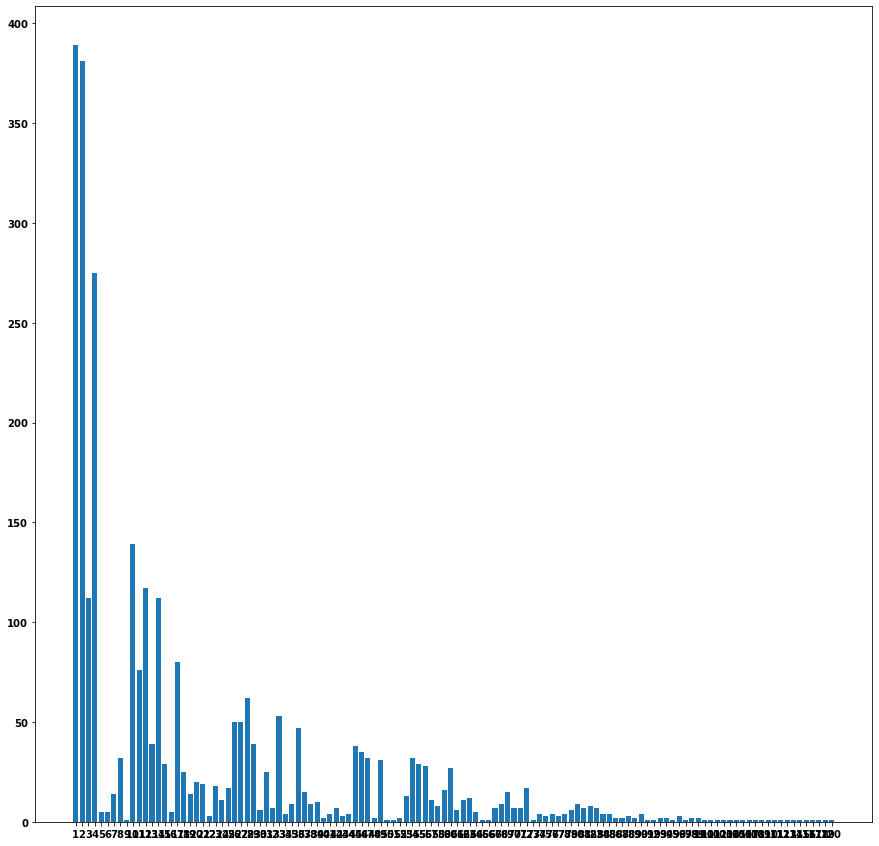

In [61]:
plt.figure(figsize=(15,15))
plt.xticks(range(1,len(clusters)+1))
plt.bar(range(1,len(clusters)+1),l)

(2321, 261, 392, 579, 680, 712, 732, 762, 818, 835, 889, 1040, 1042, 1119, 1133, 1164, 1348, 1447, 1456, 1529, 1627, 1702, 1716, 1725, 1750, 1778, 1849, 1896, 1991, 2040, 2145, 2146, 2244, 2254, 2386)


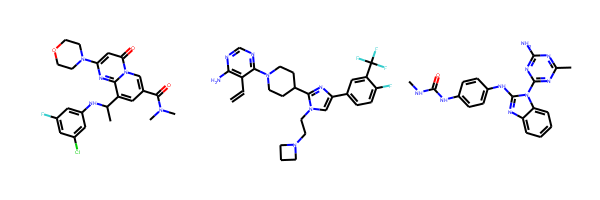

In [14]:
#show one of the clusters
print(clusters[20])
#(553, 297, 547)

#now display structures from one of the clusters
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

m1 = mol[553]
m2 = mol[297]
m3 = mol[547]
mols=(m1,m2,m3)
Draw.MolsToGridImage(mols)

In [15]:
len(clusters)

444

<h3>Feature Selection</h3>

In [111]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

for i in range(10,101,10): 
    X_new = SelectKBest(mutual_info_regression, k=i).fit_transform(X, y)
    cols = []
    for j in range(i):
        cols.append('comp'+str(j+1))
    X_red = pd.DataFrame(data=X_new, columns=cols)
    X_red['pChemBL'] = y
    X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_red)
    RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.26733787339248866	 R^2 = 0.9479117561270232
Test set results
RMSE = 0.6896876396250171	 Q^2 = 0.6388231438867185
Validation set results
RMSE = 0.6950496221708883	 Q^2 = 0.6405874030635628
Training set results:
RMSE = 0.27277202380565596	 R^2 = 0.9461701525272005
Test set results
RMSE = 0.6611262258419099	 Q^2 = 0.6611384171900576
Validation set results
RMSE = 0.6834249212476704	 Q^2 = 0.6499614877160751
Training set results:
RMSE = 0.2693904069134315	 R^2 = 0.9469766150174291
Test set results
RMSE = 0.714555936940678	 Q^2 = 0.6252680400859787
Validation set results
RMSE = 0.7640861594009303	 Q^2 = 0.5548729826769982
Training set results:
RMSE = 0.2632325822927935	 R^2 = 0.9470783918685622
Test set results
RMSE = 0.7212686075543397	 Q^2 = 0.6395663955689602
Validation set results
RMSE = 0.7382844920000958	 Q^2 = 0.6200882485234493
Training set results:
RMSE = 0.2646183416962703	 R^2 = 0.9488812219515873
Test set results
RMSE = 0.7150654963193709	 Q^2 = 0.6

In [109]:
print([i for i in range(0,51,10)])

[0, 10, 20, 30, 40, 50]


25 features(from 452) with SelectFromModel

In [117]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
reg = ExtraTreesRegressor(n_estimators=150)
reg = reg.fit(X, y)
model = SelectFromModel(reg, prefit=True,max_features=25)
X_new = model.transform(X)
X_new.shape               

(2861, 25)

In [118]:
cols = []
for i in range(X_new.shape[1]):
    cols.append('comp'+str(i+1))
X_new = pd.DataFrame(data=X_new,columns=cols)
X_new['pChemBL'] = y
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_new)
model = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.2917748287379361	 R^2 = 0.9353128704432097
Test set results
RMSE = 0.7231279051647945	 Q^2 = 0.6332444131479319
Validation set results
RMSE = 0.7141039799257112	 Q^2 = 0.6430208161103215


<h3>RFECV 452

In [9]:
from sklearn.feature_selection import RFECV
reg = RandomForestRegressor()
select = RFECV(reg,step =50,n_jobs=-1,min_features_to_select= 50,verbose=1)
select.fit(X,y)
X_new = select.transform(X)
cols = []
for i in range(X_new.shape[1]):
    cols.append('comp'+str(i+1))
X_red = pd.DataFrame(data=X_new, columns=cols)
X_red['pChemBL'] = y
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_red)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.27578056281743857	 R^2 = 0.9427413001587287
Test set results
RMSE = 0.7044532192594573	 Q^2 = 0.6390706145187659
Validation set results
RMSE = 0.7003509714774089	 Q^2 = 0.6585269884225984


In [42]:
X_red.shape

(2861, 452)

<h3>RFECV452+SKB

In [44]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFECV
#X_red.drop(columns='pChemBL',inplace=True)
selector = SelectKBest(mutual_info_regression, k=50)
X_new = selector.fit_transform(X_red, y)
cols = model.get_support(indices=True)
gc = []
all_columns = X.columns
cols = selector.get_support(indices=True)
for i in range(len(all_columns)):
    if i in cols:
        gc.append(all_columns[i])
X_red1 = pd.DataFrame(data=X_new, columns=gc)
X_red1['pChemBL'] = y
X_red1.to_csv('./data/RFEandSKB.csv',index=False)

In [45]:
X_red.shape

(2861, 451)

In [ ]:
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_red1)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

<h3> ExtraTrees + SelectFromModel

In [20]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=150)
reg = reg.fit(X_red, y)
model = SelectFromModel(reg, prefit=True)
X_new = model.transform(X_red)
X_new.shape               
cols = []
for i in range(X_new.shape[1]):
    cols.append('comp'+str(i+1))
X_new = pd.DataFrame(data=X_new,columns=cols)
X_new['pChemBL'] = y
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_new)
model = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.2735181700236474	 R^2 = 0.9451619774615067
Test set results
RMSE = 0.7119150691432141	 Q^2 = 0.6507601078202636
Validation set results
RMSE = 0.6681760434719178	 Q^2 = 0.6439455262898088


In [21]:
X_train.shape

(1830, 65)

In [47]:
X_red.columns

Index(['comp1', 'comp2', 'comp3', 'comp4', 'comp5', 'comp6', 'comp7', 'comp8',
       'comp9', 'comp10',
       ...
       'comp442', 'comp443', 'comp444', 'comp445', 'comp446', 'comp447',
       'comp448', 'comp449', 'comp450', 'comp451'],
      dtype='object', length=451)

In [46]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=150)
reg = reg.fit(X_red, y)

In [48]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(reg, prefit=True)
X_new = model.transform(X_red)
X_new.shape               
cols = X.columns
gc = []
for i in range(len(X.columns)):
    if i in model.get_support(indices=True):
        gc.append(X.columns[i])
X_new = pd.DataFrame(data=X_new,columns=gc)
X_new['pChemBL'] = y

In [49]:
X_train, X_test, X_validate, y_train, y_test, y_validate = split_data(X_new)
RFR = train_RFR(X_train, X_test, X_validate, y_train, y_test, y_validate)

Training set results:
RMSE = 0.26620189658995014	 R^2 = 0.9466377526514312
Test set results
RMSE = 0.6997386217377103	 Q^2 = 0.6386748895352093
Validation set results
RMSE = 0.6915037896285295	 Q^2 = 0.6709559035888681


In [51]:
X_new.head()

,nN,ATSC3c,AATSC2v,AATSC2p,AATSC3i,AATSC8s,MATS2c,MATS2v,MATS2p,MATS3i,...,topoRadius,topoDiameter,GGI5,VE1_D,VE2_D,MWC8,MWC9,MWC10,XLogP,pChemBL
0,5.0,-0.145569,6.520842,0.033282,-0.192045,0.005802,-0.043265,0.133123,0.151351,-0.129099,...,7.0,14.0,1.298611,0.179965,0.005293,10.570162,11.469569,12.376806,2.188,6.82
1,5.0,-0.052259,-1.311602,-0.006195,-0.119898,-0.028528,0.117528,-0.026376,-0.027534,-0.072937,...,7.0,14.0,1.350833,0.207667,0.006699,10.698763,11.619904,12.547891,6.575,7.64
2,7.0,0.078087,-4.401278,-0.004569,-0.280655,-0.112216,0.142885,-0.097913,-0.020252,-0.099931,...,10.0,19.0,1.187500,0.111470,0.003013,10.503450,11.374020,12.259002,5.589,4.30
3,15.0,0.515464,-4.768215,-0.028557,0.088748,0.336153,0.157322,-0.103900,-0.144668,0.063773,...,14.0,28.0,2.475833,0.107781,0.001684,10.727553,11.575609,12.430979,-0.194,6.03
4,1.0,-0.234616,1.831454,-0.000231,-0.152061,0.027539,-0.058844,0.038389,-0.000993,-0.105832,...,6.0,12.0,1.174722,0.074599,0.002487,10.612139,11.533502,12.463822,4.844,6.42


In [52]:
X_new.to_csv('./data/SFM452.csv',index=False)